# Probabilistic Methods (Discrete)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [ ]:
#counting based and an abitrary cut off 

**Anomaly Detection:** Identification of items, events or observations which is significantly different from the remaining data.

- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability 

    
- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$
    
    
 Examples: 
- How many times we see an ip address in the dataset (count)
- What is probability of ip address showing up in the dataset (ip count / total observations)
- Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

### Wrangle

The data comes from the webserver logs of the API that we used in the timeseries module. Each row is one request to the server

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
df.head(2)

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...


In [4]:
df['entry'][0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [5]:
df['entry'][1]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/items HTTP/1.1" 200 3561 "-" "python-requests/2.21.0"'

In [6]:
df['entry'][0].split()

#.split is really useful 

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [7]:
parts = df['entry'][0].split()
output = {}

output['ip'] = parts[0]
output['timestamp'] = parts[3][1:].replace(':', ' ', 1)


In [8]:
pd.Series(output)

ip                   97.105.19.58
timestamp    16/Apr/2019 19:34:42
dtype: object

In [9]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [10]:
df = df.entry.apply(parse_log_entry)

In [11]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [12]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


#fake data 



/var/folders/f1/8blv52r50y1cffy2qpp05b5c0000gn/T/ipykernel_38979/2524790224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [13]:
df.tail(3)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0


In [ ]:
#aking if the data they are gettign is goos 

In [14]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [15]:
df.head(2)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396


## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [16]:
# df.ip.value_counts()

In [17]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [18]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


In [19]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


From here we can find how many unique ip addresses there are:

In [20]:
ip_df.set_index('ip')['count'].sort_values()

ip
95.31.16.121          1
54.145.52.184         1
35.174.209.2          1
3.92.201.136          1
54.172.14.223         1
3.88.129.158          1
34.207.64.242         1
52.91.30.150          1
45.23.250.16          1
95.31.18.119          1
97.105.15.120         1
52.90.165.200         1
34.229.70.250         1
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
24.26.242.9          21
68.201.219.223       21
72.181.105.81       246
72.181.113.170      613
173.173.113.51     1059
97.105.19.58      11999
Name: count, dtype: int64

<AxesSubplot:ylabel='ip'>

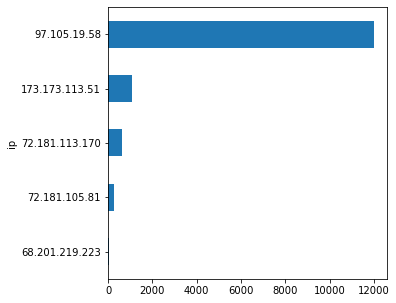

In [21]:
ip_df.set_index('ip')['count'].sort_values().tail(5).plot.barh(figsize=(5,5))

<AxesSubplot:ylabel='ip'>

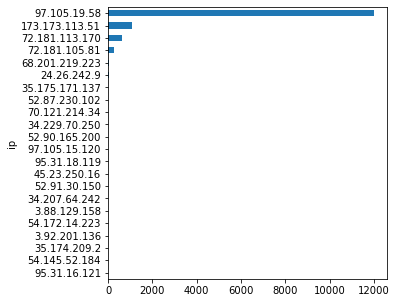

In [22]:
ip_df.set_index('ip')['count'].sort_values().plot.barh(figsize=(5,5))

### Conditional Probabilities

- What is probability of a certain status code given an IP address?

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

In [23]:
# prob(A|B) = prob(A & B)/prob(B)

In [24]:
Pab = df.groupby(['ip', 'status_code']).size()/len(df)

In [25]:
Pab

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [26]:
Pb = df.groupby('ip').size()/len(df)

In [27]:
Pb

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
dtype: float64

In [28]:
Pab / Pb
#the proba of getting the certin status code a face valeu counts 

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [29]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [30]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [31]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code', ascending=False)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:44,72.181.113.170,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:17,72.181.113.170,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.487023
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:07,72.181.113.170,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.488924
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865


* Cases where the probability is < 100%
* Status codes other than 200

In [32]:
status_given_ip[status_given_ip.status_code != 200]

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


#### How do we use this if we are looking to apply assumptions on unseen data?

In [33]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [34]:
train.size / df.size

0.9997138360280441

#### Add these probabilities to original events to detect anomalous events:

In [35]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [36]:
# look at any unseen data in df versus assumptions made on train

In [37]:
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [38]:
df[df.proba_status_given_ip < 0.15]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167


In [ ]:
#1 - all doing is value counts too which dont showw up often

#2 - combination of values to see which combinations dont show up often


Descreet methhods- use domain knowlege or just look at combinations 

## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [43]:
df.request_path.value_counts(ascending=True) #just saying how many times this ip visited 

/api/v1/I_DIDNT_DO_IT!!!!              1
/api/v1/items/api/v1/items?page=3      1
/api/v1/items?page=4                   1
/api/v1/stores?page=2                  1
/api/v1/stores?page=999                1
                                    ... 
/api/v1/stores                       162
/api/v1/items?page=3                 219
/api/v1/items?page=2                 291
/api/v1/items                        464
/api/v1/sales?page=2                 709
Name: request_path, Length: 220, dtype: int64

In [ ]:
# idk much about request paths but what is that "I DIDNT DO IT" ? weird 

In [42]:
df.request_path.nunique()

220

In [51]:
RP_df = pd.DataFrame(df.request_path.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'request_path', 'request_path': 'count'})
RP_df.head()

,request_path,count
0,/api/v1/sales?page=2,709
1,/api/v1/items,464
2,/api/v1/items?page=2,291
3,/api/v1/items?page=3,219
4,/api/v1/stores,162


In [52]:
rp_df2 = pd.DataFrame((df.request_path.value_counts(dropna=False))/df.request_path.count()).reset_index().\
                rename(columns={'index': 'request_path', 'request_path': 'proba'})
rp_df2.head()

,request_path,proba
0,/api/v1/sales?page=2,0.050723
1,/api/v1/items,0.033195
2,/api/v1/items?page=2,0.020818
3,/api/v1/items?page=3,0.015667
4,/api/v1/stores,0.011590


In [53]:
rp_df = RP_df.merge(rp_df2, on='request_path')
rp_df.head()

,request_path,count,proba
0,/api/v1/sales?page=2,709,0.050723
1,/api/v1/items,464,0.033195
2,/api/v1/items?page=2,291,0.020818
3,/api/v1/items?page=3,219,0.015667
4,/api/v1/stores,162,0.011590


In [54]:
rp_df.set_index('request_path')['count'].sort_values()

request_path
/api/V1/HiZach!                        1
/api/v1/stores?page=666                1
/api/v1/items/                         1
/api/v1/items/api/v1/items?page=3      1
/api/v1/items?page=4                   1
                                    ... 
/api/v1/stores                       162
/api/v1/items?page=3                 219
/api/v1/items?page=2                 291
/api/v1/items                        464
/api/v1/sales?page=2                 709
Name: count, Length: 220, dtype: int64

<AxesSubplot:ylabel='request_path'>

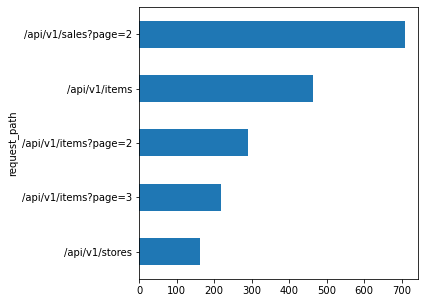

In [55]:
rp_df.set_index('request_path')['count'].sort_values().tail(5).plot.barh(figsize=(5,5))

In [56]:
df.request_path.value_counts(normalize=True, ascending=True).head(10)

/api/v1/I_DIDNT_DO_IT!!!!            0.000072
/api/v1/items/api/v1/items?page=3    0.000072
/api/v1/items?page=4                 0.000072
/api/v1/stores?page=2                0.000072
/api/v1/stores?page=999              0.000072
/api/v1/items&page=0                 0.000072
/api/v1/items?page=0                 0.000072
/api/v1/items/                       0.000072
/api/V1/HiZach!                      0.000072
/api/v1//api/v1/items                0.000072
Name: request_path, dtype: float64

In [75]:
rp_df.where(rp_df.proba < .002).value_counts()


request_path                             count  proba   
/api/V1/HiZach!                          1.0    0.000072    1
/api/v1                                  1.0    0.000072    1
/api/v1items                             2.0    0.000143    1
/api/v1/stores?page=999                  1.0    0.000072    1
/api/v1/stores?page=666                  1.0    0.000072    1
/api/v1/stores?page=3                    4.0    0.000286    1
/api/v1/stores?page=2                    1.0    0.000072    1
/api/v1/stores?page=183                  2.0    0.000143    1
/api/v1/stores?page=0                    2.0    0.000143    1
/api/v1/store                            3.0    0.000215    1
/api/v1/sales?page=79/                   3.0    0.000215    1
/api/v1/sales/?page=2                    3.0    0.000215    1
/api/v1/itemsitems                       3.0    0.000215    1
/api/v1/items?page=99999999999999999998  1.0    0.000072    1
/api/v1/items?page=4                     1.0    0.000072    1
/api/v1/items

In [ ]:
#there is a few that are weird like the hiZach one or the 99999999 one, or hello class 

In [63]:
df[df.request_path == '/api/v1/I_DIDNT_DO_IT!!!!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 20:01:02,97.105.19.58,GET,/api/v1/I_DIDNT_DO_IT!!!!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833


In [64]:
df[df.request_path == '/api/v1/items?page=99999999999999999998']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:37:26,97.105.19.58,GET,/api/v1/items?page=99999999999999999998,HTTP/1.1,200,48,python-requests/2.21.0,0.000046,0.998833


In [65]:
df[df.request_path == '/api/V1/HiZach!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833


In [67]:
df[df.request_path == '/api/v1/helloclass!']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:59:46,97.105.19.58,GET,/api/v1/helloclass!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833


In [ ]:
#well the 99 one ad the zach one happned around the same time prob like a min apaert 

#these three are all dallas ip's ? but. i know people can change it for pretection

In [61]:
df. http_version.value_counts()

HTTP/1.1    13978
Name: http_version, dtype: int64

In [62]:
df.status_code.value_counts()

200    13960
499       16
301        2
Name: status_code, dtype: int64

In [66]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

- slackbot ? like the thing on slack that tells us to git push??
- so they are using chrom as a browser?

In [71]:
df[df.user_agent == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 21:49:21,97.105.19.58,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,0.998833
2019-04-16 21:49:22,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,0.998833
2019-04-17 02:18:07,72.181.113.170,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,0.996737
2019-04-17 02:18:07,72.181.113.170,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,0.996737


In [76]:
df[df.user_agent == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-17 01:25:07,70.121.214.34,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,1.0
2019-04-17 01:25:07,70.121.214.34,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,1.0


In [77]:
df[df.user_agent == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:38:16,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:44:04,97.105.19.58,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266,0.998833
2019-04-16 19:44:04,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:44:16,97.105.19.58,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266,0.998833
2019-04-16 19:44:16,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:44:24,97.105.19.58,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266,0.998833
2019-04-16 19:44:24,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:44:28,97.105.19.58,GET,/api/v1/stores?page=2,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.001266,0.998833


In [ ]:
#the 72.181 is a san antonio ip

#the 97.105 is a dallas ip- the weeird request paths are from a dallas ip and they are ahppening around the same time 

In [78]:
df[df.user_agent == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-17 01:25:07,72.181.105.81,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040,1.0
2019-04-17 01:25:21,72.181.105.81,GET,/documentation,HTTP/1.1,200,348,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332,1.0
2019-04-17 01:33:06,72.181.105.81,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.003489,1.0
2019-04-17 01:33:19,72.181.105.81,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001704,1.0
2019-04-17 01:33:32,72.181.105.81,GET,/api/v1/items?page=4,HTTP/1.1,200,48,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046,1.0
2019-04-17 01:56:33,72.181.105.81,GET,/api/v1/stores,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266,1.0
2019-04-17 01:56:57,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025,1.0
2019-04-17 02:07:44,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025,1.0


In [79]:
df[df.user_agent == 'python-requests/2.21.0']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,0.998833
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,0.998833
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,0.998833
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,0.998833
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,0.998833
...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532,0.998833
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591,1.000000
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958,1.000000
